# Consumer Utility Distribution Analysis

This notebook analyzes the simulation results (`results.csv`) to visualize the distribution of consumer utility across different scenarios and prices.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Preprocessing

In [8]:
# Load the results
df = pd.read_csv("results.csv")

# Convert 'persona_dist' from string to a more readable label if necessary
# Assuming 'persona_dist' column contains string representation of dictionary
def parse_persona_dist(dist_str):
    try:
        d = ast.literal_eval(dist_str)
        # Create a simplified label, e.g., "B:0.7, N:0.15, S:0.15"
        return f"B:{d.get('Bandwagon',0):.2f}, N:{d.get('Neutral',0):.2f}, S:{d.get('Snob',0):.2f}"
    except:
        return dist_str

if 'persona_dist' in df.columns:
    df['Scenario'] = df['persona_dist'].apply(parse_persona_dist)
else:
    df['Scenario'] = "Default"

# Ensure initial_price is sorted
prices = sorted(df['initial_price'].unique())

# Filter for the final step of each RunId
# This ensures we are looking at the final state of the simulation
# and implicitly handles iterations by including all final states for the same parameters.
max_steps = df.groupby('RunId')['Step'].transform('max')
df_final = df[df['Step'] == max_steps].copy()

print(f"Original shape: {df.shape}")
print(f"Filtered for final step shape: {df_final.shape}")

Original shape: (18360000, 26)
Filtered for final step shape: (360000, 26)


## 2. Violin Plot: Utility Distribution vs Price

Visualizing how the distribution of `CurrentUtility` changes as `initial_price` increases for each Persona and Scenario.
To avoid overcrowding, we display only a subset of price points.

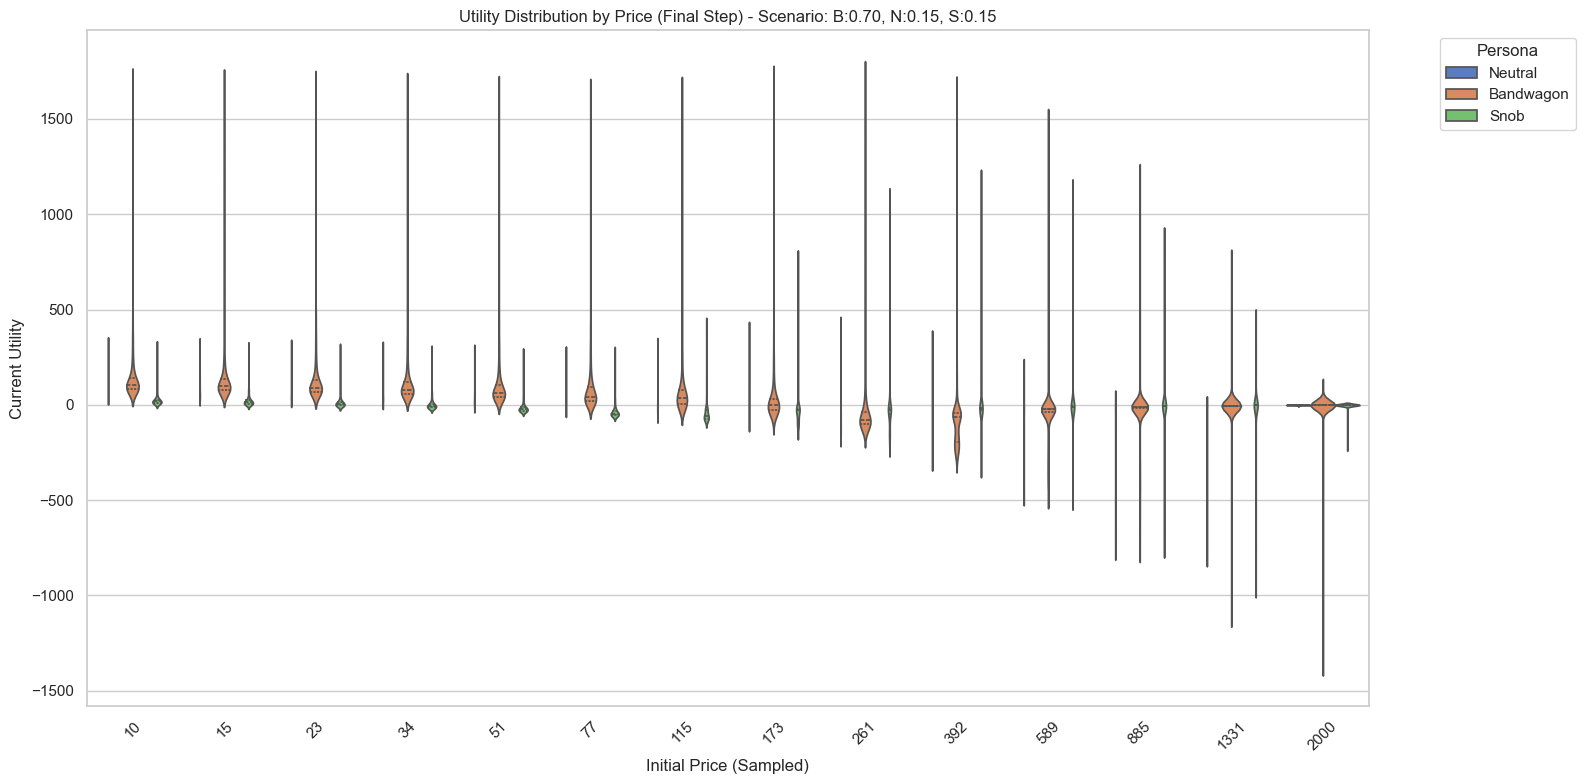

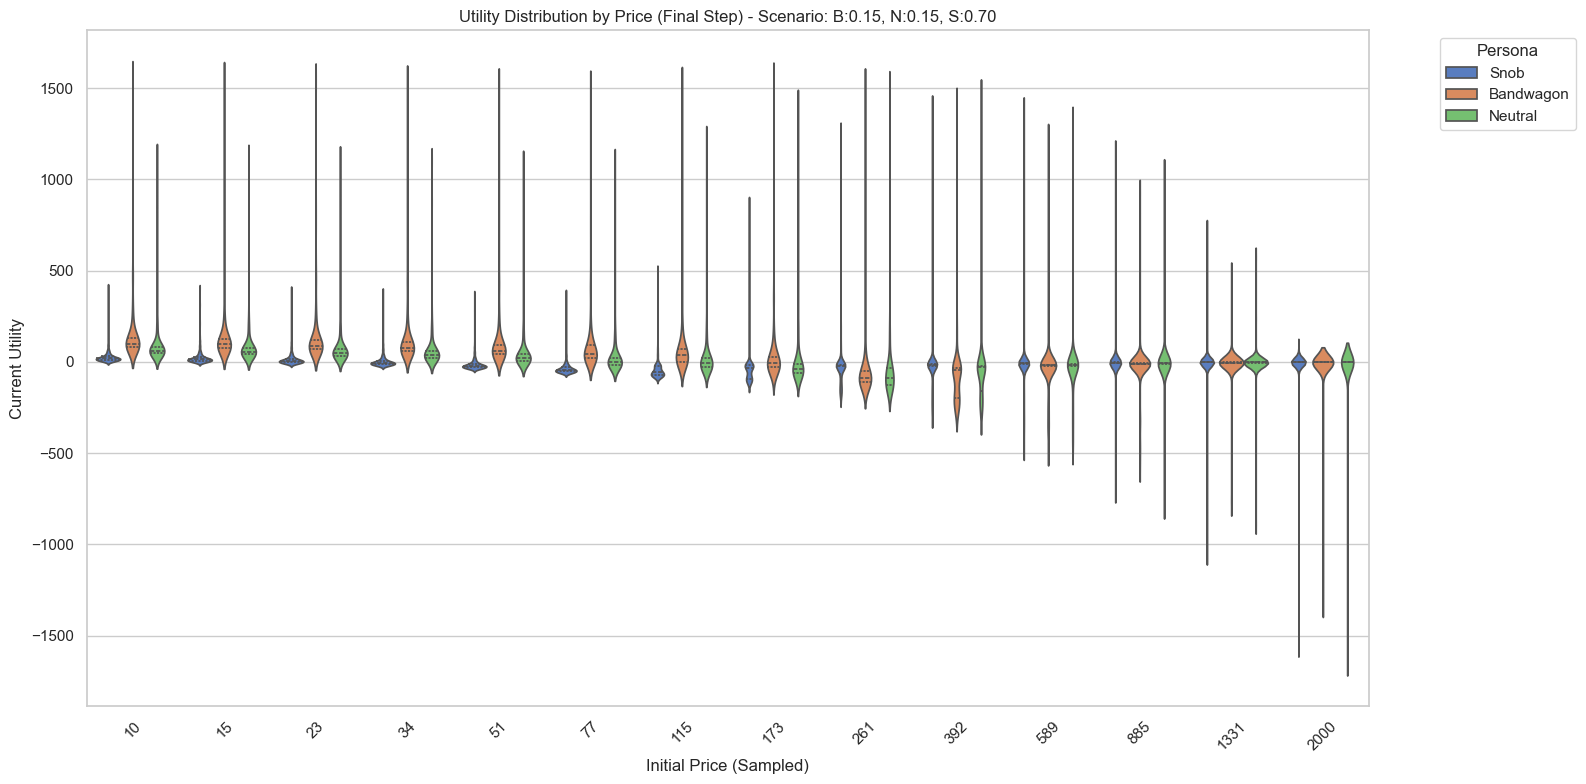

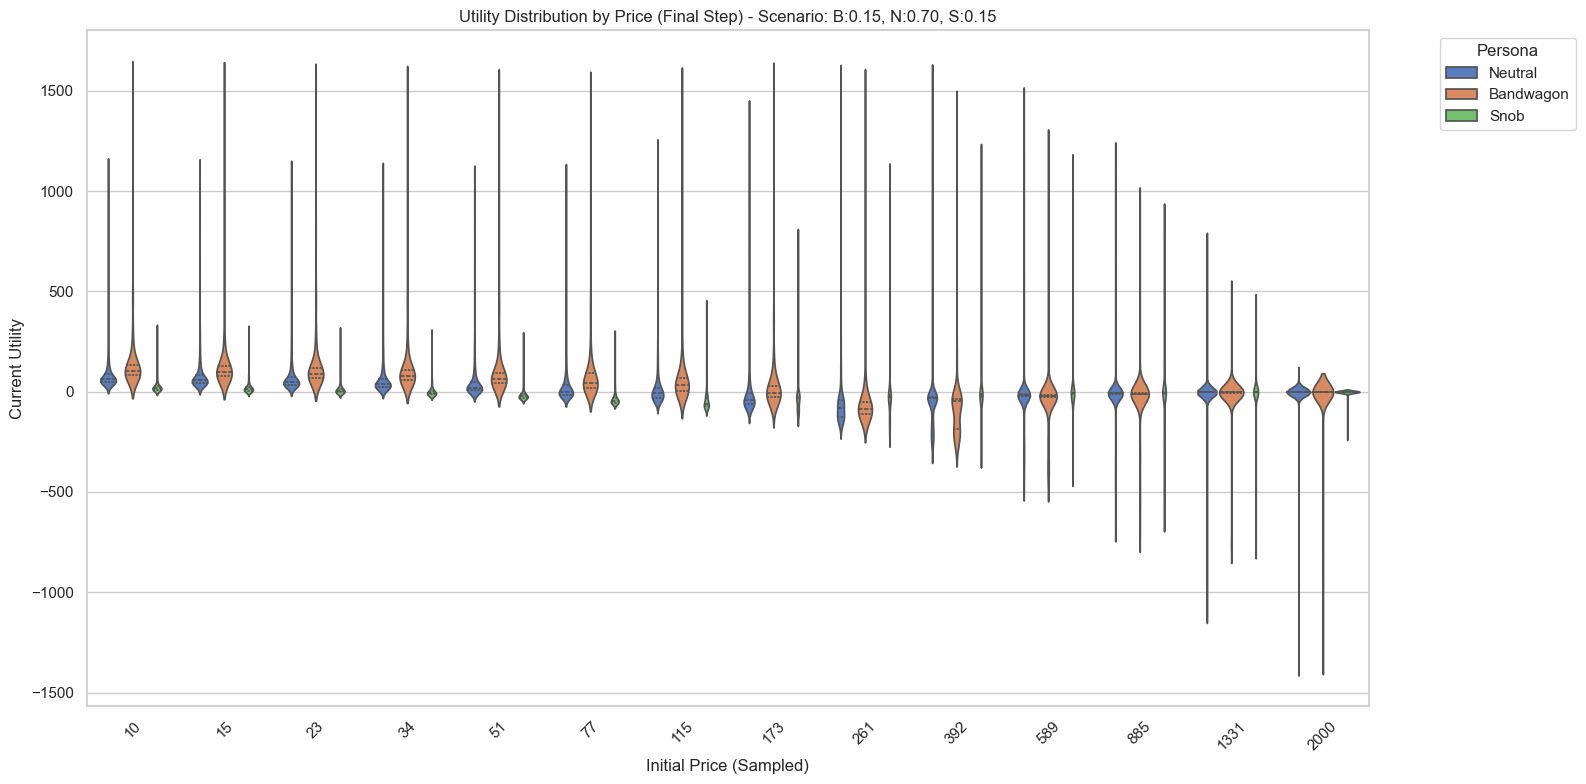

In [9]:
scenarios = df_final['Scenario'].unique()

# Subsample prices for visualization (e.g., every 3rd price)
# This makes the violin plot less crowded
display_prices = prices[::3]

for scenario in scenarios:
    # Filter for scenario and selected prices
    subset = df_final[(df_final['Scenario'] == scenario) & (df_final['initial_price'].isin(display_prices))]
    
    plt.figure(figsize=(16, 8))
    
    sns.violinplot(data=subset, x='initial_price', y='CurrentUtility', hue='Persona', 
                   split=False, inner='quartile', palette='muted')
    
    plt.title(f"Utility Distribution by Price (Final Step) - Scenario: {scenario}")
    plt.xlabel("Initial Price (Sampled)")
    plt.ylabel("Current Utility")
    plt.xticks(rotation=45)
    plt.legend(title='Persona', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## 3. Detailed Histograms at Selected Prices

Examining the shape of the utility distribution at specific price points (Low, Medium, High).

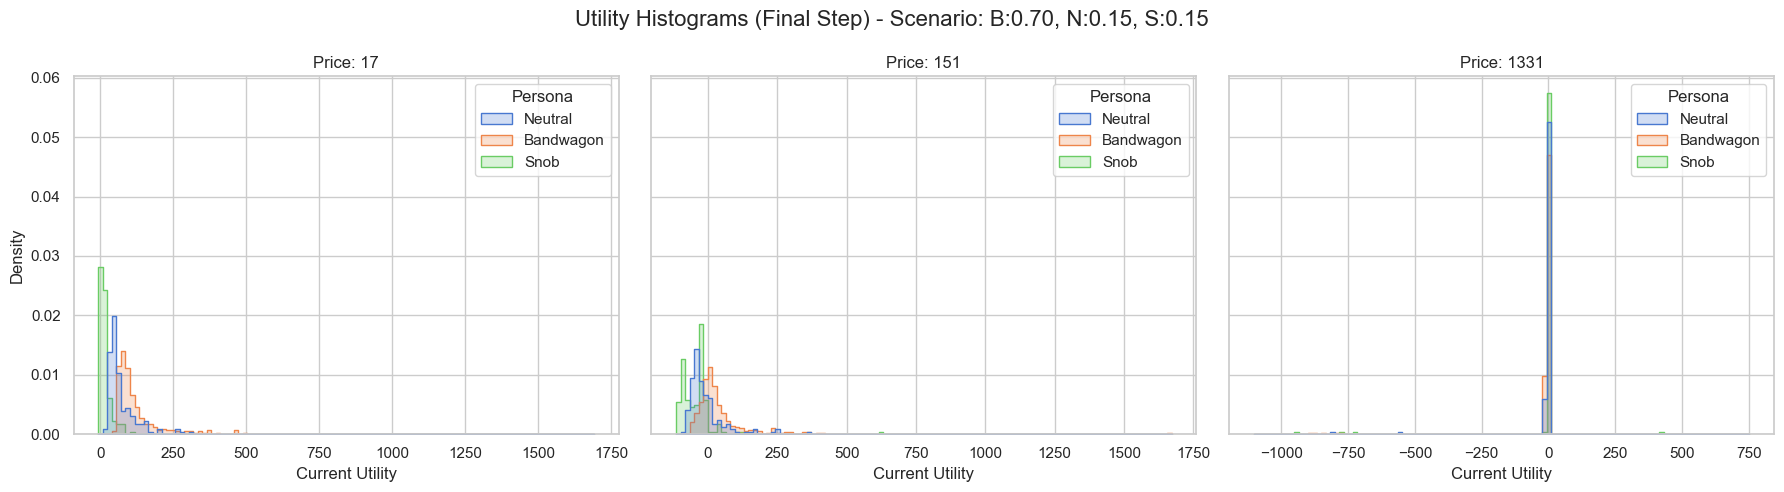

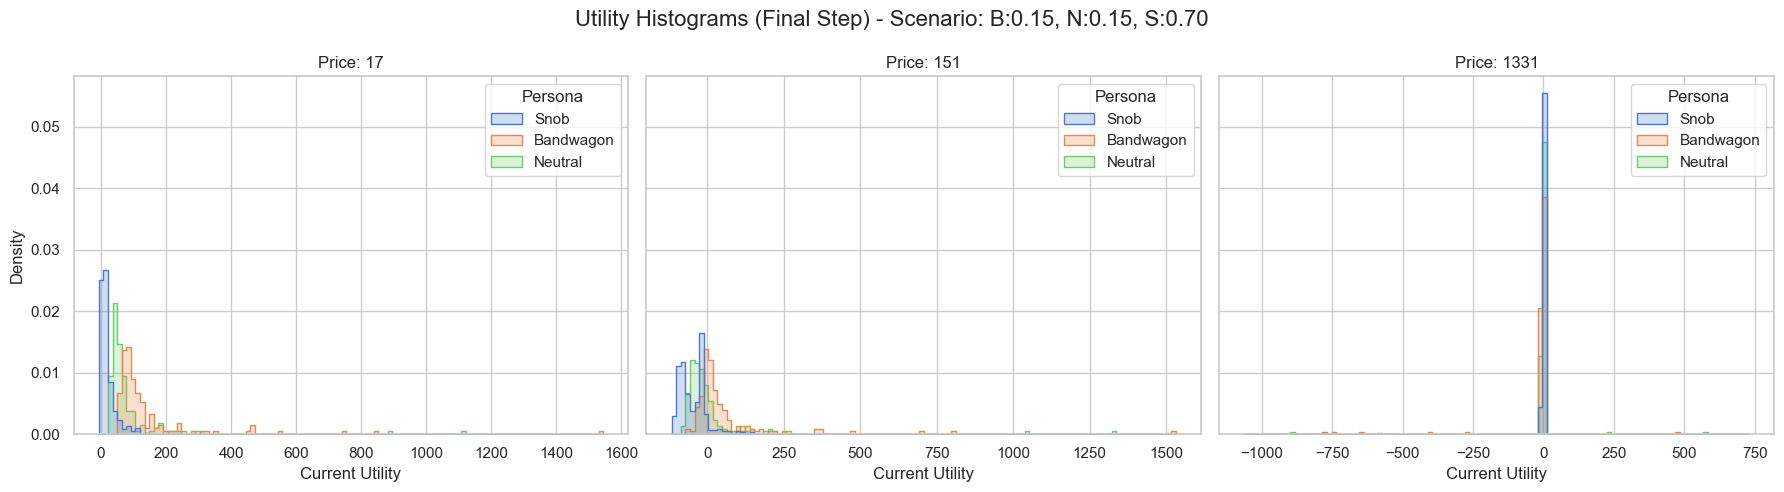

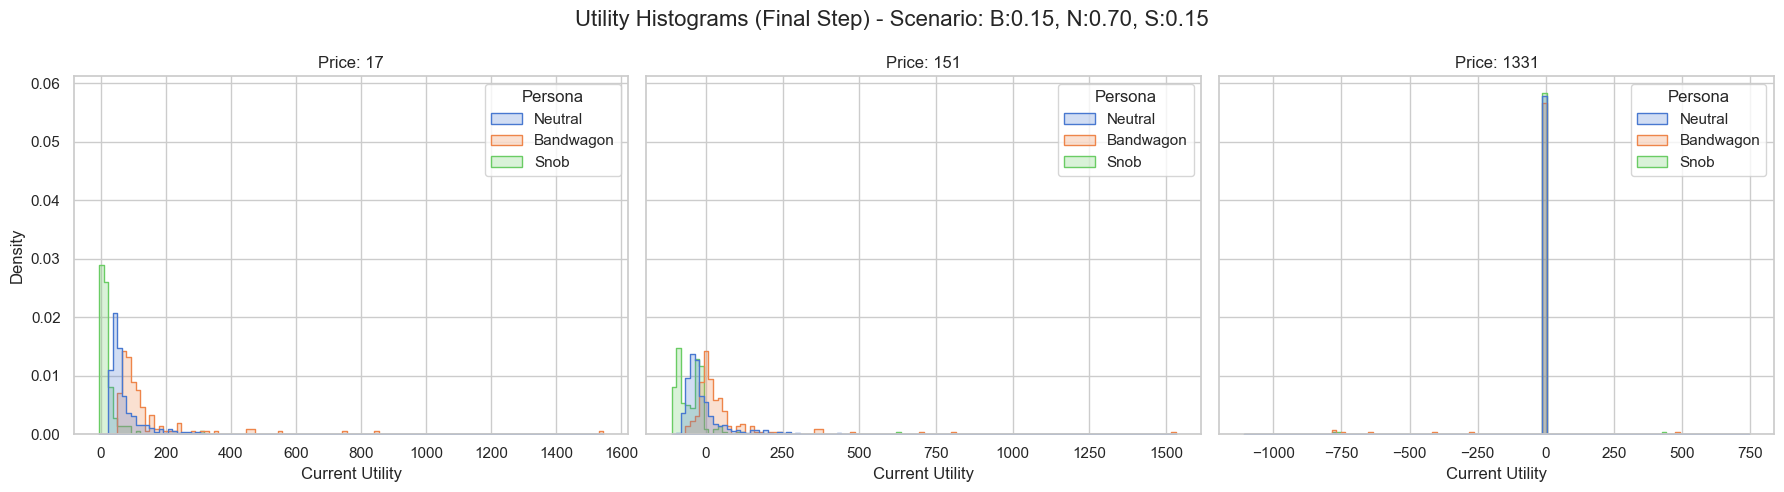

In [10]:
# Select 3 representative prices
low_price = prices[len(prices)//10]   # ~10th percentile index
mid_price = prices[len(prices)//2]    # Median index
high_price = prices[int(len(prices)*0.9)] # ~90th percentile index

selected_prices = [low_price, mid_price, high_price]

for scenario in scenarios:
    subset_scenario = df_final[df_final['Scenario'] == scenario]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle(f"Utility Histograms (Final Step) - Scenario: {scenario}", fontsize=16)
    
    for i, price in enumerate(selected_prices):
        subset_price = subset_scenario[subset_scenario['initial_price'] == price]
        
        sns.histplot(data=subset_price, x='CurrentUtility', hue='Persona', 
                     element="step", stat="density", common_norm=False, ax=axes[i], palette='muted')
        
        axes[i].set_title(f"Price: {price}")
        axes[i].set_xlabel("Current Utility")
    
    plt.tight_layout()
    plt.show()

## 4. Zero Utility / Non-Buyer Ratio

Analyzing the proportion of agents with zero utility (often indicating non-participation or indifference) across prices.

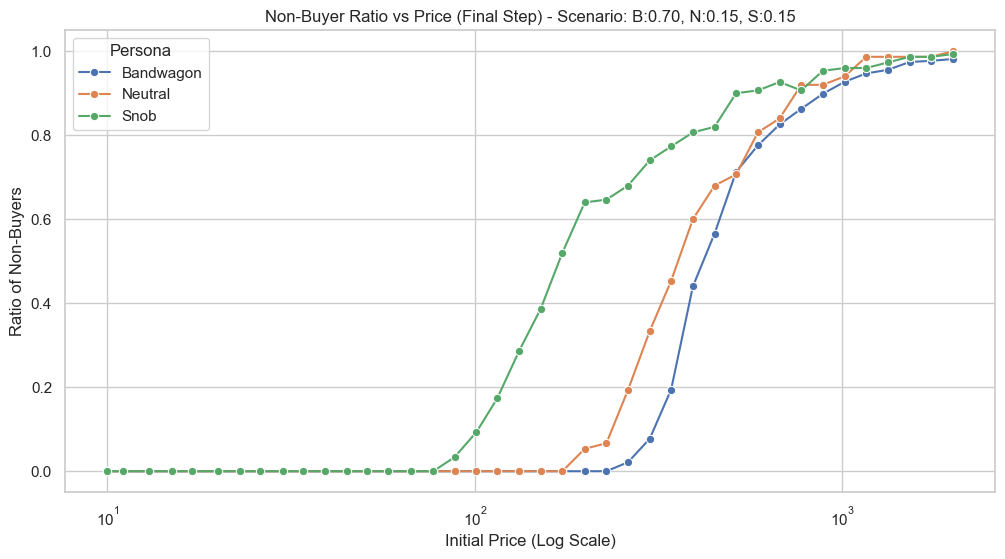

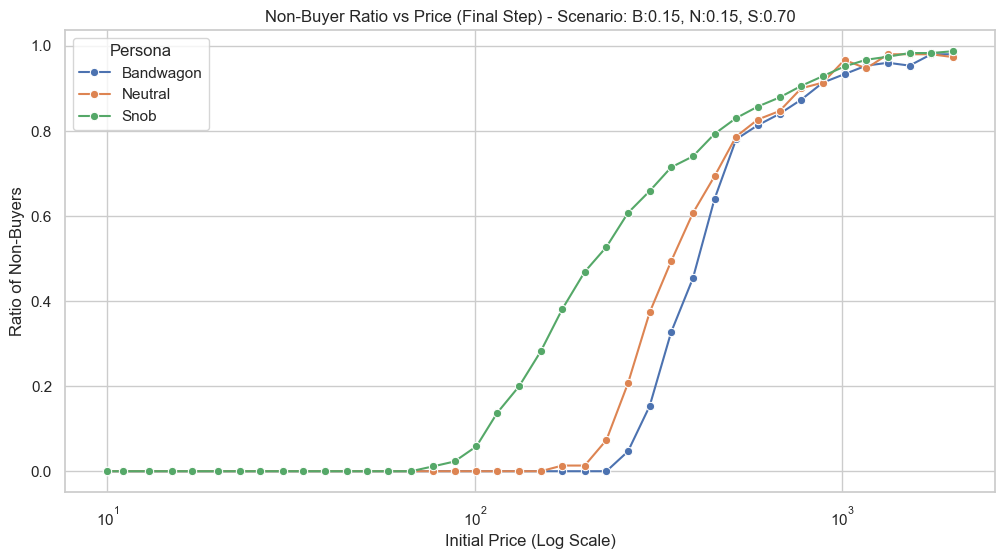

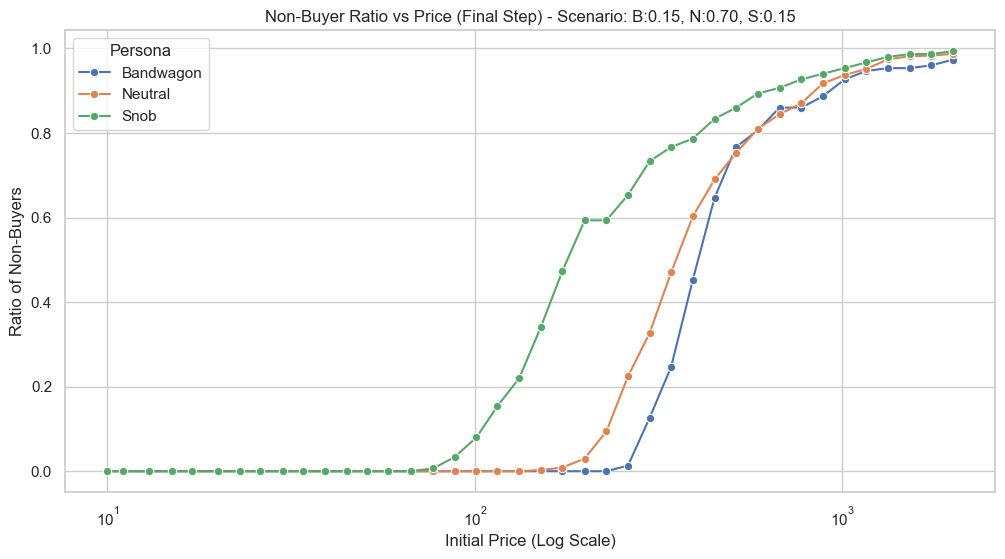

In [19]:
# Calculate ratio of 0 utility per price per persona per scenario
df_final['IsZeroUtility'] = df_final['CurrentUtility'] == 0
df_final['IsNonBuyer'] = ~df_final['HasToken']

grouped = df_final.groupby(['Scenario', 'initial_price', 'Persona'])[['IsZeroUtility', 'IsNonBuyer']].mean().reset_index()

for scenario in scenarios:
    subset = grouped[grouped['Scenario'] == scenario]
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=subset, x='initial_price', y='IsNonBuyer', hue='Persona', marker='o')
    
    plt.xscale('log')
    plt.title(f"Non-Buyer Ratio vs Price (Final Step) - Scenario: {scenario}")
    plt.xlabel("Initial Price (Log Scale)")
    plt.ylabel("Ratio of Non-Buyers")
    plt.show()

## 3. Impact of Data Ownership on Utility

Violin plots comparing the `CurrentUtility` of agents who have data vs those who do not.

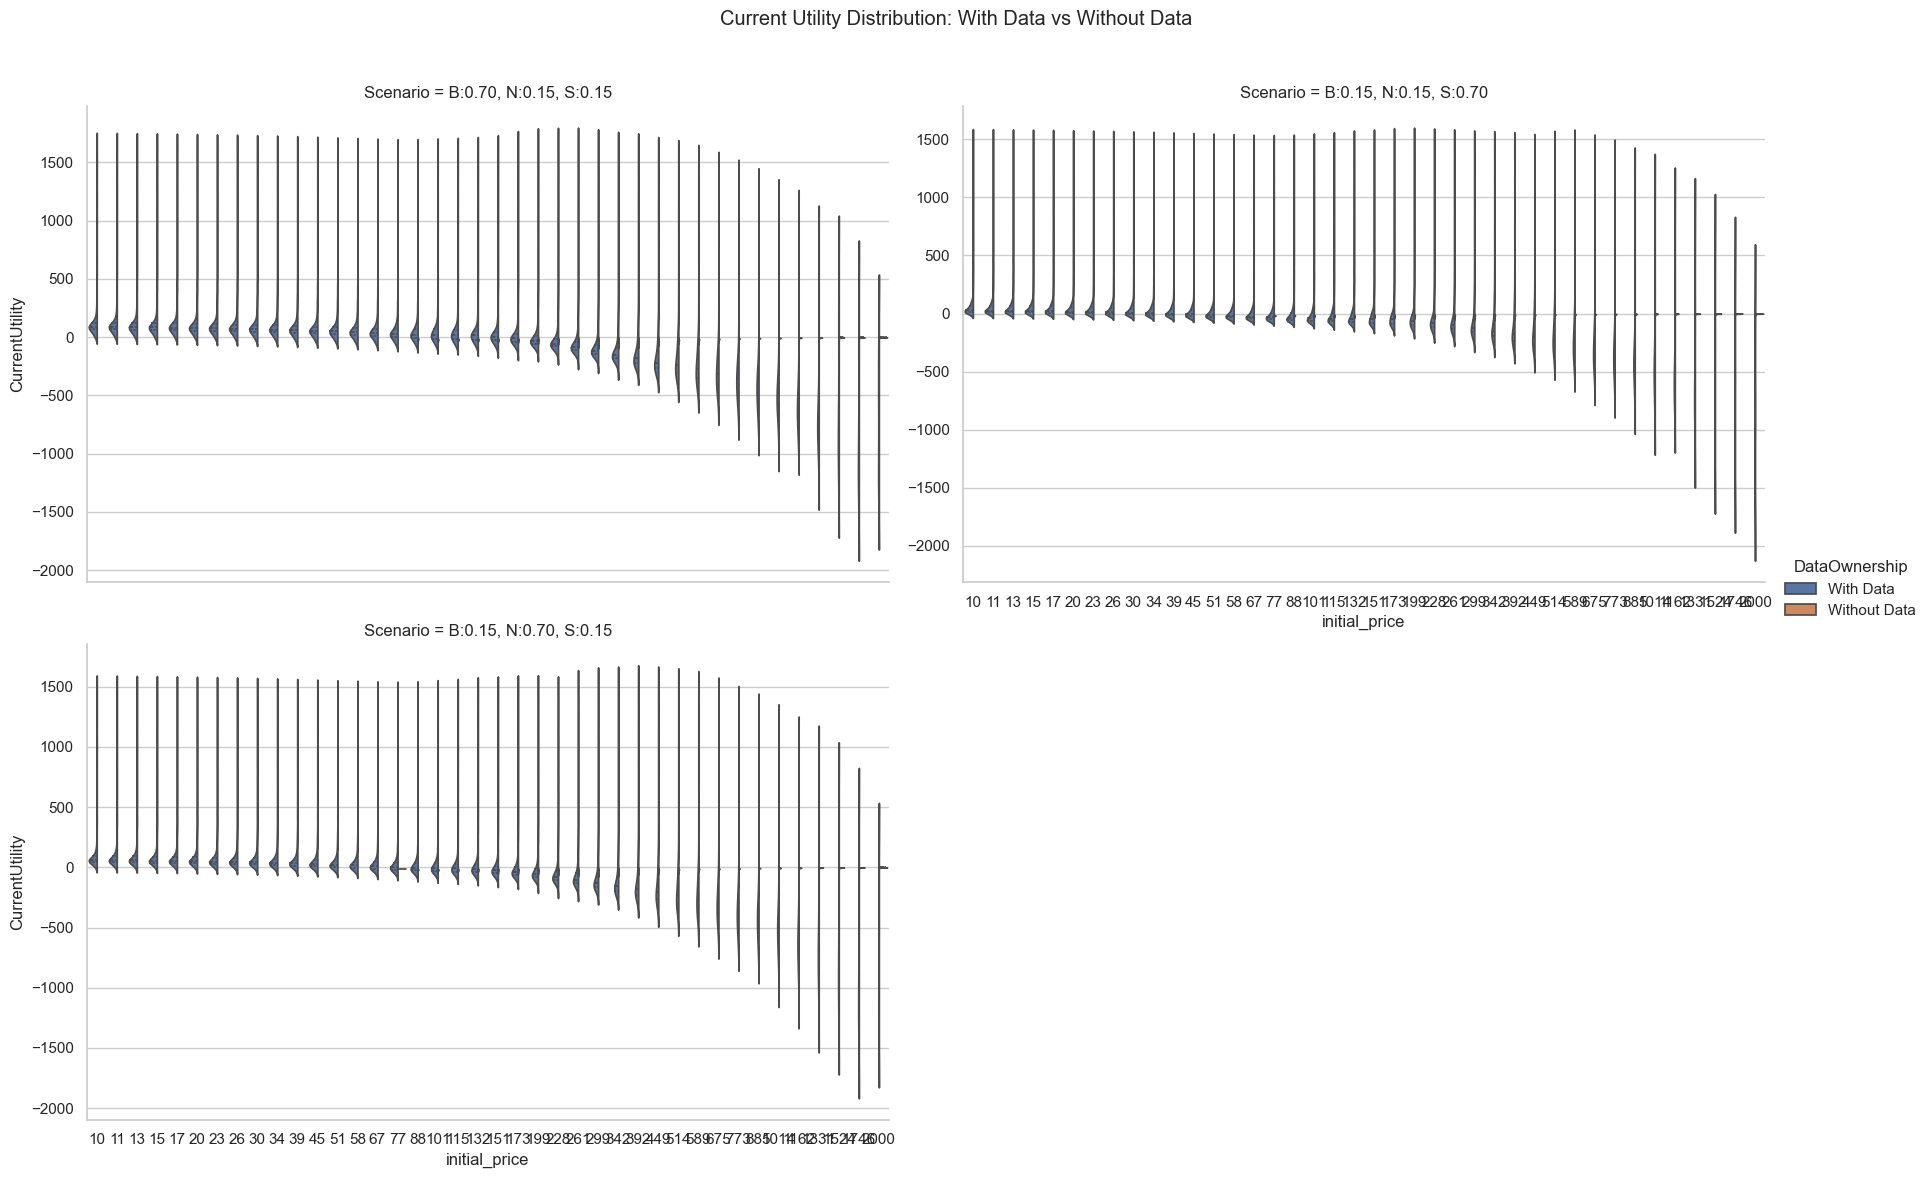

In [20]:
# Create a label for Data Ownership
df_final['DataOwnership'] = df_final['HasToken'].map({True: 'With Data', False: 'Without Data'})

# Plot Violin Plot using catplot to handle scenarios
g = sns.catplot(
    data=df_final, 
    kind="violin", 
    x="initial_price", 
    y="CurrentUtility", 
    hue="DataOwnership", 
    split=True, 
    inner="quartile",
    col="Scenario",
    col_wrap=2,
    height=6, 
    aspect=1.5,
    sharey=False
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Current Utility Distribution: With Data vs Without Data')
plt.show()

## 4. Utility Distribution for Non-Data Holders

Violin plots showing the distribution of `CurrentUtility` specifically for agents who do **not** have data.

Number of agents without data: 119607


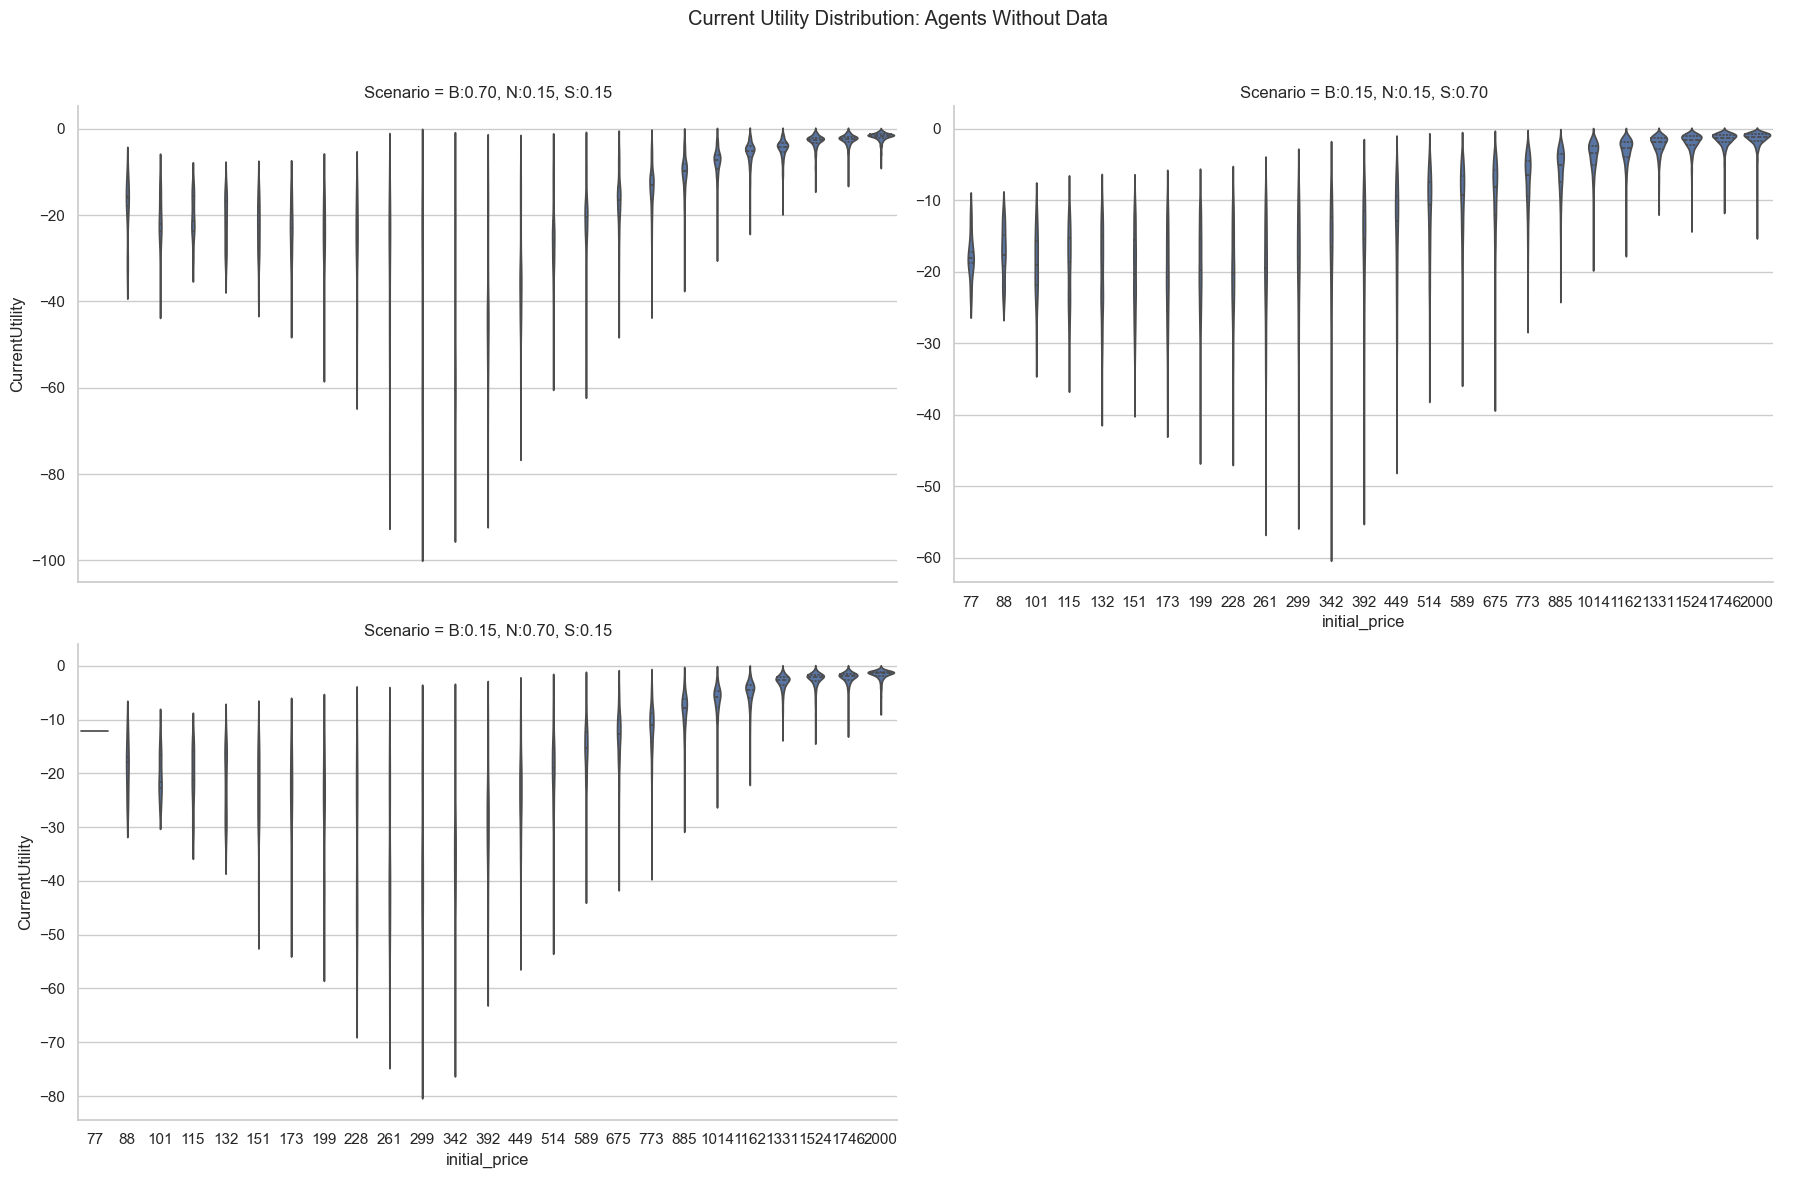

In [21]:
# Ensure HasToken is boolean (handle potential string representation from CSV)
if df_final['HasToken'].dtype == 'object':
    df_final['HasToken'] = df_final['HasToken'].astype(str).map({'True': True, 'False': False, 'true': True, 'false': False})

# Filter for agents without data
df_no_data = df_final[df_final['HasToken'] == False].copy()
print(f"Number of agents without data: {len(df_no_data)}")

# Plot Violin Plot for Non-Data Holders
g = sns.catplot(
    data=df_no_data, 
    kind="violin", 
    x="initial_price", 
    y="CurrentUtility", 
    col="Scenario",
    col_wrap=2,
    height=6, 
    aspect=1.5,
    sharey=False,
    inner="quartile"
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Current Utility Distribution: Agents Without Data')
plt.show()